In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [73]:
full_train_orig = pd.read_csv("../Data/application_train.csv")
test =  pd.read_csv("../Data/application_test.csv")

In [74]:
test.shape

(48744, 121)

In [75]:
bureau = pd.read_csv("../Data/bureau.csv")
bureau_gb = bureau.groupby("SK_ID_CURR")[["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "CNT_CREDIT_PROLONG", "DAYS_CREDIT_UPDATE"
                             , "AMT_CREDIT_SUM_OVERDUE", "AMT_CREDIT_SUM"]].mean().reset_index()

In [76]:
full_train_orig = pd.merge(full_train_orig, bureau_gb, how="inner", on="SK_ID_CURR")
test = pd.merge(test, bureau_gb, how="left", on="SK_ID_CURR")

In [77]:
'''
Removing columns with more than 100 null values (filters out 62 columns out of 122 columns)
And not useful (based on EDA) which removes reduces feature size to 43)
'''

null_columns = full_train_orig.columns[full_train_orig.isnull().sum().values > 10000].values.tolist()
useless_columns = ["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_7"
                  ,'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [78]:
### Manually removing columns which doesn't make sense (based on EDA)
full_train = full_train_orig.drop(null_columns+useless_columns, axis = 1)

In [79]:
#cat_columns_all = set(full_train.columns) - set(full_train._get_numeric_data().columns.tolist())

In [80]:
# cat_feats = ["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
#              "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE",
#              "NAME_HOUSING_TYPE", "FLAG_DOCUMENT_3"]
# num_feats = ["AMT_INCOME_TOTAL", "CNT_CHILDREN", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "DAYS_BIRTH",
#              "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_LAST_PHONE_CHANGE", "AMT_REQ_CREDIT_BUREAU_YEAR", 
#             "REGION_POPULATION_RELATIVE", ]

In [81]:
full_train_y = full_train.TARGET.values
full_train = full_train.drop(["TARGET"], axis = 1)
full_train = full_train.set_index("SK_ID_CURR")
num_feats = full_train._get_numeric_data().columns.values.tolist()
cat_feats = list(set(full_train.columns.values) - set(num_feats))

In [82]:
## Categorical Features - Train
train_cat= full_train[cat_feats]
train_cat = pd.get_dummies(train_cat)

## Numerical Features - Train
train_num = full_train[num_feats]
# train[num_feats].isnull().any() # Checking if the column has any null value
train_num = train_num.fillna((train_num.mean()))

## Categorical Features - Test
test_cat = test[cat_feats]
test_cat = pd.get_dummies(test_cat)

## Numerical Features - Test
test_num = test[num_feats]
test_num = test_num.fillna(test_num.mean())

# ## Standardize numerical features
# std = StandardScaler().fit(train_num)
# train_num = std.transform(train_num)
# test_num = std.transform(test_num)


In [83]:
full_train_feats = pd.concat([train_num, train_cat], axis=1)
test_feats = pd.concat([test_num, test_cat], axis=1)

In [84]:
full_train_feats = full_train_feats.apply(lambda x: x.fillna(x.mean()),axis=0)
test_feats = test_feats.apply(lambda x: x.fillna(x.mean()),axis=0)

In [85]:
train_X, valid_X, train_y, valid_y = train_test_split(full_train_feats, full_train_y, train_size = 0.8, stratify=full_train_y)

# Random Forest Classifier

In [ ]:
# ### RF classifier
# params_rf={
#     'max_depth': [20, 40, 60], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
#     'n_estimators': [100, 300, 500], #[1000,2000,3000]
# }

# rf_clf = RandomForestClassifier()
# rf = GridSearchCV(rf_clf,
#                   params_rf,
#                   cv=3,
#                   scoring="roc_auc",
#                   n_jobs=1,
#                   verbose=2)
# rf.fit(train_X.drop("CODE_GENDER_XNA", axis=1), train_y)
# best_est_rf = rf.best_estimator_
# print(best_est)

In [ ]:
valid_probs_rf = rf.predict_proba(valid_X.drop("CODE_GENDER_XNA", axis=1))[:,1]
valid_preds_rf = rf.predict(valid_X.drop("CODE_GENDER_XNA", axis=1))

In [ ]:
print(accuracy_score(valid_y, valid_preds_rf))
print(roc_auc_score(valid_y, valid_probs_rf))

# XGboost with Grid Search

In [ ]:
params={
    'max_depth': [3, 5], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6, 0.8], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    #'colsample_bytree': [0.5, 0.7], #[0.5,0.6,0.7,0.8],
    'n_estimators': [300, 500], #[1000,2000,3000]
    #'reg_alpha': [0.01, 0.05] #[0.01, 0.02, 0.03, 0.04]
    'scale_pos_weight':[1,3,5]
}

xgb_clf = xgb.XGBClassifier(missing=9999999999)
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=2)
rs.fit(train_X.drop("CODE_GENDER_XNA", axis=1), train_y)
best_est = rs.best_estimator_
print(best_est)

In [59]:
xgb_single = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=9999999999, n_estimators=300,
       nthread=-1, objective='binary:logistic', reg_alpha=0.05,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8)

xgb_single.fit(train_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1), train_y)
valid_probs_xgb_single = xgb_single.predict_proba(valid_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1))[:,1]
valid_preds_xgb_single = xgb_single.predict(valid_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1))
print(accuracy_score(valid_y, valid_preds_xgb_single))
print(roc_auc_score(valid_y, valid_probs_xgb_single))

0.9226930302282775
0.7311426072668485


In [ ]:
valid_probs_rs = rs.predict_proba(valid_X.drop("CODE_GENDER_XNA", axis=1))[:,1]
valid_preds_rs= rs.predict(valid_X.drop("CODE_GENDER_XNA", axis=1))
print(accuracy_score(valid_y, valid_preds_rs))
print(roc_auc_score(valid_y, valid_probs_rs))

# LightGBM model 

In [62]:
params={
    'max_depth': [2, 3], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    #'subsample': [0.4, 0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    #'colsample_bytree': [0.5, 0.7], #[0.5,0.6,0.7,0.8],
    'n_estimators': [300, 500], #[1000,2000,3000]
    'reg_alpha': [0.01, 0.05], #[0.01, 0.02, 0.03, 0.04]
    'scale_pos_weight':[1,3], 
    'num_leaves':[20, 40]
    
}

lgb_clf = lgb.LGBMClassifier()
rs = GridSearchCV(lgb_clf,
                  params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=2)
rs.fit(train_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1), train_y)
best_est = rs.best_estimator_
print(best_est)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1, total=   5.6s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1, total=   5.9s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1, total=   8.2s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3, total=   5.3s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3, total=   5.8s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.01, scale_pos_weight=3, total=  10.2s
[CV] num_leaves=20, max_depth=2, n_estimators=300, reg_alpha=0.05, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=2, n_estimators=300, reg

[CV]  num_leaves=40, max_depth=2, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3, total=  13.8s
[CV] num_leaves=40, max_depth=2, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3 
[CV]  num_leaves=40, max_depth=2, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3, total=  11.9s
[CV] num_leaves=40, max_depth=2, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3 
[CV]  num_leaves=40, max_depth=2, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3, total=  11.5s
[CV] num_leaves=20, max_depth=3, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=3, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1, total=   9.3s
[CV] num_leaves=20, max_depth=3, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=3, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1, total=   8.4s
[CV] num_leaves=20, max_depth=3, n_estimators=300, reg_alpha=0.01, scale_pos_weight=1 
[CV]  num_leaves=20, max_depth=3, n_estimators=300, reg

[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.01, scale_pos_weight=3, total=  15.0s
[CV] num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1 
[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1, total=  16.0s
[CV] num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1 
[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1, total=  15.4s
[CV] num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1 
[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=1, total=  24.9s
[CV] num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3 
[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3, total=  14.1s
[CV] num_leaves=40, max_depth=3, n_estimators=500, reg_alpha=0.05, scale_pos_weight=3 
[CV]  num_leaves=40, max_depth=3, n_estimators=500, reg

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 21.7min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.05, reg_lambda=0.0, scale_pos_weight=3, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [63]:
valid_probs_rs = rs.predict_proba(valid_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1))[:,1]
valid_preds_rs= rs.predict(valid_X.drop(list(set(train_X.columns.tolist()) - set(test_feats.columns.tolist())), axis=1))
print(accuracy_score(valid_y, valid_preds_rs))
print(roc_auc_score(valid_y, valid_probs_rs))

0.9127118161634946
0.7320031550001073


In [88]:
best = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.05, reg_lambda=0.0, scale_pos_weight=3, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
best.fit(full_train_feats.drop(list(set(full_train_feats.columns.tolist()) - set(test_feats.columns.tolist())), axis=1), full_train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.05, reg_lambda=0.0, scale_pos_weight=3, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Prepare Submission file 

In [91]:
### Prepare submission file and save to disk
result_df = pd.DataFrame({'SK_ID_CURR':test.SK_ID_CURR.values, "TARGET":best.predict_proba(test_feats)[:,1]})
result_df.to_csv("submimssion_2_lightgbm_gridsearch_fulldata_bureau.csv", index=False)

In [23]:
full_train_orig.columns[full_train_orig.isnull().sum() < 10000]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCI

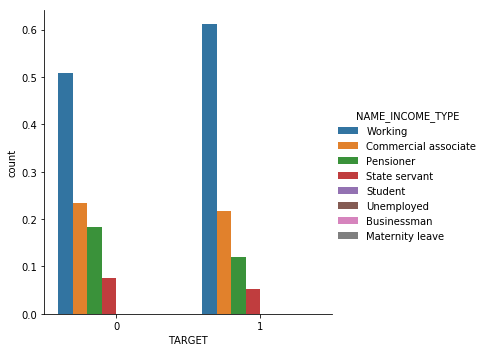

In [51]:
col = "NAME_INCOME_TYPE"
bla = full_train_orig.groupby("TARGET")[col].value_counts(normalize=True).reset_index(name="count")
sns.catplot(x="TARGET", y = "count", hue= col, data= bla, kind="bar")

In [48]:
bla

,TARGET,FLAG_OWN_REALTY,count
0,0,Y,0.690942
1,0,N,0.309058
2,1,Y,0.680381
3,1,N,0.319619
